# 7. Vertical Vibration of Quarter Car Model

This notebook introduces the base excitation system by examning the behavior of a quarter car model.

After the completion of this assignment students will be able to:

- excite a system with a sinusoidal input
- understand the difference in transient and steady state solutions
- create a frequency response plot
- define resonance and determine the parameters that cause resonance

![](fig/07/quarter-car.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from resonance.linear_systems import SimpleQuarterCarSystem

In [2]:
sys = SimpleQuarterCarSystem()

The simple quarter car model has a suspension stiffness and damping, along with the sprung car mass in kilograms, and a travel speed parameter in meters per second.

In [3]:
sys.constants

{'sprung_mass': 1007,
 'suspension_damping': 2000.0,
 'suspension_stiffness': 40000.0,
 'travel_speed': 7.5}

In [4]:
sys.coordinates

{'car_vertical_position': -0.05}

In [5]:
sys.speeds

{'car_vertical_velocity': 0.0}

# A sinusoidal road

The road is described as:

$$y(t) = Ysin\omega_b t$$

where $Y$ is the amplitude of the sinusoidal road undulations and $\omega_b$ is the frequency of the a function of the car's speed. If the distance between the peaks (amplitude 0.01 meters) of the sinusoidal road is 6 meters and the car is traveling at 7.5 m/s calculate what the frequency will be.

In [6]:
Y = 0.01  # m
v = sys.constants['travel_speed']
bump_distance = 6  # m
wb = v / bump_distance * 2 * np.pi  # rad /s

In [7]:
print(wb)

7.853981633974483


Now with the amplitude and frequency set you can use the `sinusoidal_base_displacing_response()` function to simulate the system.

In [8]:
traj = sys.sinusoidal_base_displacing_response(Y, wb, 20.0)

In [9]:
traj.head()

,car_vertical_position,car_vertical_position_acc,car_vertical_velocity,forcing_function,road_height
time,,,,,
0.00,-0.050000,2.142085,4.163336e-17,157.079633,0.000000
0.01,-0.049893,2.126124,2.134873e-02,187.979047,0.000785
0.02,-0.049574,2.100977,4.249185e-02,217.719508,0.001564
0.03,-0.049044,2.066746,6.333799e-02,246.117655,0.002334
0.04,-0.048308,2.023569,8.379694e-02,272.998406,0.003090


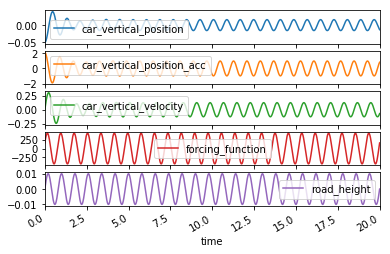

In [10]:
traj.plot(subplots=True);

We've written an animation for you. You can play it with:

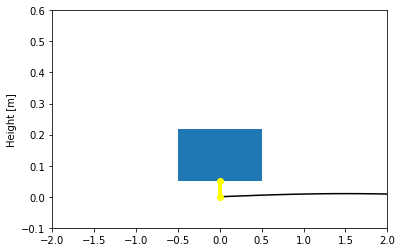

In [11]:
sys.animate_configuration(interval=1000/100)

**Exercise**

Try different travel speeds and see what kind of behavior you can observe. Make sure to set the `travel_speed` constant and the frequency value for `sinusoidal_base_displacing_response()` to be consistent.

# Transmissibility

When designing a car the designer wants the riders to feel comfortable and to isolate them from the road's bumps. There are two important aspect to investigate. The first is called *displacement transmissibility* and is a ratio between the ampitude of the steady state motion and the ampitude of the sinusoidal base displacement. So in our case this would be:

$$ \frac{X}{Y}(\omega_b) = \frac{\textrm{Steady State Amplitude}}{\textrm{Base Displacement Amplitude}} $$

This can be plotted as a function of the base displacement frequency. A car suspension designer may want this ratio to be an optimal value for rider comfort.

**Exercise**

Use the curve fitting technique from the previous notebook to plot $X/Y$ for a range of frequencies. Your code  should look something like:

```python
from scipy.optimize import curve_fit

def cosine_func(times, amp, freq, phase_angle):
    return amp * np.cos(freq * times - phase_angle)

frequencies = np.linspace(1.0, 10.0, num=100)
   
amplitudes = []
    
for omega in frequencies:
    # your code here

amplitudes = np.array(amplitudes)

fig, ax = plt.subplots(1, 1, sharex=True)
ax.set_xlabel('$\omega_b$ [rad/s]')
ax.set_ylabel('Displacement Transmissibility') 

ax.axvline(, color='black') # natural frequency
ax.plot()#?
ax.grid();
```

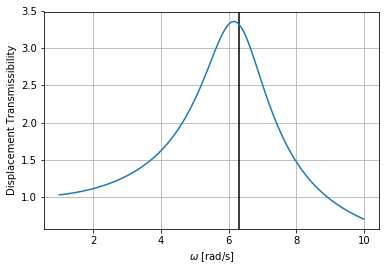

In [12]:
from scipy.optimize import curve_fit
def cosine_func(times, amp, freq, phase_angle):
    return amp * np.cos(freq * times - phase_angle)
frequencies = np.linspace(1.0, 10.0, num=100)
   
amplitudes = []
    
for omega in frequencies:
    traj = sys.sinusoidal_base_displacing_response(Y, omega, 20.0)
    popt, pcov = curve_fit(cosine_func,
                           traj[10:].index, traj[10:].car_vertical_position,
                           p0=(Y, omega, 0.05))
    amplitudes.append(abs(popt[0]))

amplitudes = np.array(amplitudes)

fig, ax = plt.subplots(1, 1, sharex=True)
ax.set_xlabel('$\omega$ [rad/s]')
ax.set_ylabel('Displacement Transmissibility') 

ax.axvline(np.sqrt(sys.constants['suspension_stiffness'] / sys.constants['sprung_mass']), color='black')
ax.plot(frequencies, amplitudes / Y)
ax.grid();

In [13]:
# write you answer here

The second thing to investigate is the *force transmissibility*. This is the ratio of the force applied by the suspension to the sprung car. Riders will feel this force when the car travels over bumps. Reducing this is also preferrable.

**Excersice**

Create a measurement to calculate the force on the car.

In [14]:
def force_on_car(suspension_damping, suspension_stiffness, car_vertical_position, car_vertical_velocity, time):
    y = Y * np.sin(wb * time)
    yd = Y * wb * np.cos(wb * time)
    return (suspension_damping * (car_vertical_velocity - yd) +
            suspension_stiffness * (car_vertical_position - y))

In [15]:
# write your answer here

In [16]:
sys.add_measurement('force_on_car', force_on_car)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4bdf50f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fb465c017f0>], dtype=object)

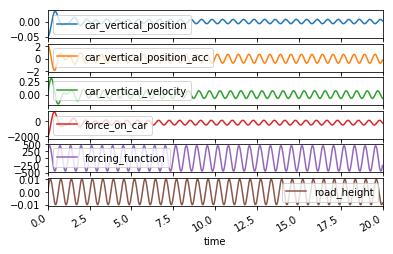

In [17]:
traj = sys.sinusoidal_base_displacing_response(Y, omega, 20.0)
traj.plot(subplots=True)

#  Arbitrary Periodic Forcing (Fourier Series)

Fourier discovered that any periodic function with a period $T$ can be described by an infinite series of sums of sines and cosines. See the wikipedia article for more info (https://en.wikipedia.org/wiki/Fourier_series). The key equation is this:

$$ F(t) = \frac{a_0}{2} + \sum_{n=1}^\infty (a_n \cos n\omega_T t + b_n \sin n \omega_T t)$$

The terms $a_0, a_n, b_n$ are called the Fourier coefficients and are defined as such:

$$ a_0 = \frac{2}{T} \int_0^T F(t) dt$$

$$ a_n = \frac{2}{T} \int_0^T F(t) \cos n \omega_T t dt \quad \textrm{for} \quad n = 1, 2, \ldots $$

$$ b_n = \frac{2}{T} \int_0^T F(t) \sin n \omega_T t dt \quad \textrm{for} \quad n = 1, 2, \ldots $$


## Introduction to SymPy

SymPy is a Python package for symbolic computing. It can do many symbolic operations, for instance, integration, differentiation, linear algebra, etc. See http://sympy.org for more details of the features and the documentation. Today we will cover how to do integrals using SymPy and use it to find the Fourier series that represents a sawtooth function.

In [18]:
import sympy as sm

The function `init_printing()` enables LaTeX based rendering in the Jupyter notebook of all SymPy objects.

In [19]:
sm.init_printing()

Symbols can be created by using the `symbols()` function.

In [20]:
x, y, z = sm.symbols('x, y, z')

In [21]:
x, y, z

The `integrate()` function allows you to do symbolic indefinite or definite integrals. Note that the constants of integration are not included in indefinite integrals.

In [22]:
sm.integrate(x * y, x)

The `Integral` class creates and unevaluated integral, where as the `integrate()` function automatically evaluates the integral.

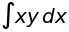

In [23]:
expr = sm.Integral(x * y, x)
expr

To evaluate the unevaluated form you call the `.doit()` method. Note that all unevaluated SymPy objects have this method.

In [24]:
expr.doit()

This shows how to create an unevaluated definite integral, store it in a variable, and then evaluate it.

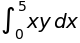

In [25]:
expr = sm.Integral(x * y, (x, 0, 5))
expr

In [26]:
expr.doit()

# Fourier Coefficients for the Sawtooth function

Now let's compute the Fourier coefficients for a saw tooth function. The function that describes the saw tooth is:

$$
F(t) = 
\begin{cases} 
      A \left( \frac{4t}{T} - 1 \right) & 0 \leq t \leq T/2 \\
      A \left( 3 - \frac{4t}{t} \right) & T/2 \leq t \leq T 
\end{cases}
$$

where:

- $A$ is the amplitude of the saw tooth
- $T$ is the period of the saw tooth
- $\omega_T$ is the frequency of the saw tooth, i.e. $\omega_T = \frac{2\pi}{T}$
- $t$ is time

This is a piecewise function with two parts from $t=0$ to $t=T$.

In [27]:
A, T, wT, t = sm.symbols('A, T, omega_T, t', real=True, positive=True)
A, T, wT, t

The first Fourier coefficient $a_0$ describes the average value of the periodic function. and is:

$$a_0 = \frac{2}{T} \int_0^T F(t) dt$$

This integral will have to be done in two parts:

$$a_0 = a_{01} + a_{02} = \frac{2}{T} \int_0^{T/2} F(t) dt + \frac{2}{T} \int_{T/2}^T F(t) dt$$

These two integrals are evaluated below. Note that $a_0$ evaluates to zero. This is because the average of our function is 0.

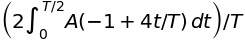

In [28]:
ao_1 = 2 / T * sm.Integral(A * (4 * t / T - 1), (t, 0, T / 2))
ao_1

In [29]:
ao_1.doit()

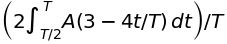

In [30]:
ao_2 = 2 / T * sm.Integral(A * (3 - 4 * t / T), (t, T / 2, T))
ao_2

In [31]:
ao_2.doit()

But SymPy can also handle piecewise directly. The following shows how to define a piecewise function.

In [32]:
F_1 = A * (4 * t / T - 1)
F_2 = A * (3 - 4 * t / T)

In [33]:
F = sm.Piecewise((F_1, t<=T/2),
                 (F_2, T/2<t))
F

⎧  ⎛     4⋅t⎞          T
⎪A⋅⎜-1 + ───⎟  for t ≤ ─
⎪  ⎝      T ⎠          2
⎨                       
⎪  ⎛    4⋅t⎞       T    
⎪A⋅⎜3 - ───⎟   for ─ < t
⎩  ⎝     T ⎠       2    

The integral can be taken of the entire piecewise function in one call.

In [34]:
sm.integrate(F, (t, 0, T))

Now the Fourier coefficients $a_n$ and $b_n$ can be computed.

$$
a_n = \frac{2}{T}\int_0^T F(t) \cos n\omega_Tt dt \\
b_n = \frac{2}{T}\int_0^T F(t) \sin n\omega_Tt dt
$$

In [35]:
n = sm.symbols('n', real=True, positive=True)

For $a_n$:

In [36]:
an = 2 / T * sm.Integral(F * sm.cos(n * wT * t), (t, 0, T))
an

  T                                         
  ⌠                                         
  ⎮ ⎧  ⎛     4⋅t⎞                       T   
  ⎮ ⎪A⋅⎜-1 + ───⎟⋅cos(n⋅ω_T⋅t)  for t ≤ ─   
  ⎮ ⎪  ⎝      T ⎠                       2   
2⋅⎮ ⎨                                     dt
  ⎮ ⎪  ⎛    4⋅t⎞                    T       
  ⎮ ⎪A⋅⎜3 - ───⎟⋅cos(n⋅ω_T⋅t)   for ─ < t   
  ⎮ ⎩  ⎝     T ⎠                    2       
  ⌡                                         
  0                                         
────────────────────────────────────────────
                     T                      

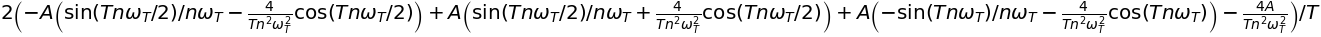

In [37]:
an.doit()

This can be simplified:

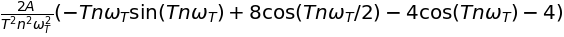

In [38]:
an = an.doit().simplify()
an

Now substitute the $2\pi/T$ for $\omega_T$.

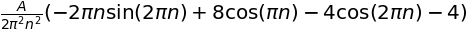

In [39]:
an = an.subs({wT: 2 * sm.pi / T})
an

Let's see how this function varies with increasing $n$. We will use a loop but the SymPy expressions will not automatically display because they are inside a loop. So we need to use SymPy's `latex()` function and the IPython display tools. SymPy's `latex()` function  transforms the SymPy expression into a string of matching LaTeX commands.

In [40]:
sm.latex(an, mode='inline')

'$\\frac{A}{2 \\pi^{2} n^{2}} \\left(- 2 \\pi n \\sin{\\left (2 \\pi n \\right )} + 8 \\cos{\\left (\\pi n \\right )} - 4 \\cos{\\left (2 \\pi n \\right )} - 4\\right)$'

The `display()` and `LaTeX()` functions then turn the LaTeX string in to a displayed version.

In [41]:
from IPython.display import display, Latex 

Now we can see how $a_n$ varies with $n=1,2,\ldots$.

In [42]:
for n_i in range(1, 6):
    ans = an.subs({n: n_i})
    display(Latex('$a_{} = $'.format(n_i) + sm.latex(ans, mode='inline')))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

For even $n$ values the coefficient is zero and for even values it variers with the inverse of $n^2$. More precisely:

$$
a_n =
\begin{cases}
0 & \textrm{if }n\textrm{ is even} \\
-\frac{8A}{n^2\pi^2} & \textrm{if }n\textrm{ is odd}
\end{cases}
$$

SymPy can actually reduce this further if your set the assumption that $n$ is an integer.

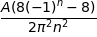

In [43]:
n = sm.symbols('n', real=True, positive=True, integer=True)
an = 2 / T * sm.Integral(F * sm.cos(n * wT * t), (t, 0, T))
an = an.doit().simplify()
an.subs({wT: 2 * sm.pi / T})

The odd and even versions can be computed by setting the respective assumptions.

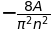

In [44]:
n = sm.symbols('n', real=True, positive=True, integer=True, odd=True)
an = 2 / T * sm.Integral(F * sm.cos(n * wT * t), (t, 0, T))
an = an.doit().simplify()
an.subs({wT: 2 * sm.pi / T})

Note that $b_n$ is always zero:

In [45]:
bn = 2 / T * sm.Integral(F * sm.sin(n * wT * t), (t, 0, T))
bn

  T                                         
  ⌠                                         
  ⎮ ⎧  ⎛     4⋅t⎞                       T   
  ⎮ ⎪A⋅⎜-1 + ───⎟⋅sin(n⋅ω_T⋅t)  for t ≤ ─   
  ⎮ ⎪  ⎝      T ⎠                       2   
2⋅⎮ ⎨                                     dt
  ⎮ ⎪  ⎛    4⋅t⎞                    T       
  ⎮ ⎪A⋅⎜3 - ───⎟⋅sin(n⋅ω_T⋅t)   for ─ < t   
  ⎮ ⎩  ⎝     T ⎠                    2       
  ⌡                                         
  0                                         
────────────────────────────────────────────
                     T                      

In [46]:
bn.doit().simplify().subs({wT: 2 * sm.pi / T})

# Numerical evalution of the Fourier Series

Now the Fourier coefficients can be used to plot the approximation of the saw tooth forcing function.

In [47]:
import numpy as np

The following function plots the actual sawtooth function. It does it all in one line by cleverly using the absolute value and the modulo functions.

In [48]:
def sawtooth(A, T, t):
    return (4 * A / T) * (T / 2 - np.abs(t % T - T / 2) ) - A

In [49]:
A = 1
T = 2
t = np.linspace(0, 5, num=500)

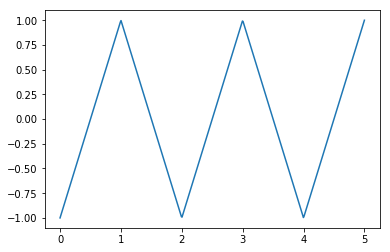

In [50]:
plt.figure()

plt.plot(t, sawtooth(A, T, t));

# Exercise

Write a function that computes the Fourier approximation of the sawtooth function for a given value of $n$, i.e. using a finite number of terms. Then plot it for $n=2, 4, 6, 8, 10$ on top of the actual sawtooth function. How many terms of the infinite series are needed to get a good sawtooth?

```python
def sawtooth_approximation(n, A, T, t):
    # code here
    return f

# plot sawtooth
f = sawtooth(A, T, t)
plt.plot(t, f, color='k', label='true sawtooth')

for n in np.arange(2, 12, 2):
    f_approx = sawtooth_approximation(n, A, T, t)
    plt.plot(t, f_approx, label='n = {}'.format(n))

plt.legend()
# zoom in a bit on the interesting bit
plt.xlim(0, T)
```

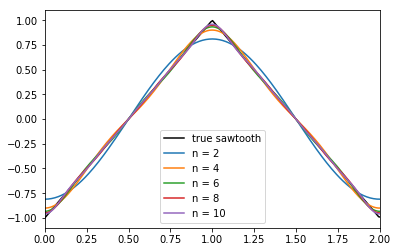

In [51]:
def sawtooth_approximation(n, A, T, t):
    # odd values of indexing variable up to n
    n_i = np.arange(1, n+1, 2)[:, np.newaxis]
    # cos coefficients
    an = -8 * A / (n_i**2 * np.pi**2)
    # sawtooth frequency
    wT = 2 * np.pi / T
    # sum of n cos functions
    f = np.sum(an * np.cos(n_i * wT * t), axis=0)
    return f

# plot sawtooth
f = sawtooth(A, T, t)
plt.plot(t, f, color='k', label='true sawtooth')

for n in np.arange(2, 12, 2):
    f_approx = sawtooth_approximation(n, A, T, t)
    plt.plot(t, f_approx, label='n = {}'.format(n))

plt.legend()
# zoom in a bit on the interesting bit
plt.xlim(0, T)

In [52]:
# write answer here

# Apply the sawtooth to the quarter car

Now that you know the Fourier series coefficients. Calculate them for a suitable number of terms and simulate them with the `sys.periodic_base_displacing_response()` function.

In [53]:
def fourier_coeffs(A, T, N):
    n = np.arange(1, N+1, 2)
    an_odd = -8 * A / (n**2 * np.pi**2)
    an_even = np.zeros_like(an_odd)
    x = list(an_even)
    for i, v in enumerate(an_odd):
        x.insert(2*i+1, v)
    an = np.asarray(x)
    return 0, an, np.zeros_like(an)

a0, an, bn = fourier_coeffs(0.01, 2 * np.pi / wb, 100)

traj = sys.periodic_base_displacing_response(a0, an, bn, wb, 20.0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4638ad860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fb463798320>], dtype=object)

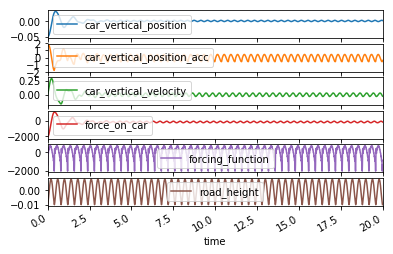

In [54]:
traj.plot(subplots=True)